In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO

from deepcoil import DeepCoil
from deepcoil.utils import plot_preds

import os
import re

In [2]:
os.getcwd()

'/ebio/abt1_share/prediction_hendecads/repo/code'

## Extracting Stretches

In [42]:
input_file = "/home/enno/uni/SS23/thesis/code/ss_data/final_dataset.fasta"

fasta_sequences = list(SeqIO.parse(open(input_file),'fasta'))
n_seq = len(fasta_sequences)

In [43]:
df = pd.DataFrame(columns=['id', 'seq', 'stretch_ix', 'stretch_seq'])

In [44]:
pattern = r'\[\[.*?\]\]'
ix = 0

for seq_ix, seq in enumerate(fasta_sequences):
    
    print(f"Processing sequence {seq_ix+1}/{n_seq}", end='\r')

    s = str(seq.seq)
    d = str(seq.description)

    stretches = eval(re.findall(pattern, d.split('|||')[-1])[0])

    for st_ix, st in enumerate(stretches):
        df = df.append({'id': seq.id, 'seq': s, 'stretch_ix': st, 'stretch_seq': s[st[0]:st[1]]}, ignore_index=True)

df.head()

,id,seq,stretch_ix,stretch_seq
0,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 71]",rlvyvavaailcsfsttslagaektakragkfvektatragkfver...
1,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 238]",eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqeed...
2,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 73]",erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaetas...
3,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 540]",aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaqsq...
4,WP_026306873.1,MLLRRIARPLLSAAFIAEGIDILQNPGPLADRLSPALDFTRRRSQH...,"[172, 342]",slgwrgrraardakdhaealaataaaiaatarergtnlvdtarert...


In [45]:
len(df)

40590

In [46]:
out_file = '/home/enno/uni/SS23/thesis/code/ss_data/stretches.fasta'

with open(out_file, 'w') as f:
    for i, row in df.iterrows():

        print(f"Writing sequence {i+1}/{len(df)}", end='\r')

        f.write(f">{row['id']}_{row['stretch_ix']}\n{row['stretch_seq']}\n")

In [47]:
inp = {str(entriy.id): str(entriy.seq) for entriy in SeqIO.parse(out_file, 'fasta')}
inp_ = {k: inp[k] for k in list(inp)[:1000]}

## DeepCoil

In [49]:
dc = DeepCoil(use_gpu=False)
inp = {str(entry.id): str(entry.seq) for entry in SeqIO.parse(out_file, "fasta")}

for i in range(0, len(df), 1000):
    print(f"Processing sequences {i+1}-{min(i+1000, len(df))}", end='\r')

    tmp_keys = list(inp.keys())[i:i+1000]
    tmp_inp = {k: inp[k] for k in tmp_keys}

    preds = dc.predict(tmp_inp)
    averages = [np.mean(preds[key]['cc']) for key in preds.keys()]

    df.loc[i:i+1000-1, 'avg_cc'] = averages

    df.to_csv('/ebio/abt1_share/prediction_hendecads/data/stretches_w_values.csv', index=False)

## CLANS

### Visualize CC propensity for groups

In [50]:
clans_df = pd.DataFrame(columns=['group_id', 'type', 'hide', 'size', 'color', 'numbers'])

clans_data = "/home/enno/uni/SS23/thesis/code/deepcoil_data/seqgroups.txt"

with open(clans_data, 'r') as file:
    data = file.read()

# Split the data by 'name='
group_data = re.split(r'name=', data)[1:]

for group_str in group_data:
    group_lines = group_str.strip().split('\n')
    
    group = {'group_id': group_lines[0], 
             'type': group_lines[1].split('=')[-1], 
             'size': group_lines[2].split('=')[-1],
             'hide': group_lines[3].split('=')[-1],
             'color': group_lines[4].split('=')[-1], 
             'numbers': list(map(int, group_lines[5].split('=')[-1].split(';')))}
    
    clans_df = clans_df.append(group,  ignore_index=True)

clans_df

,group_id,type,hide,size,color,numbers
0,group_0,0,0,10,0;196;255;255,"[32770, 6, 32774, 9, 32779, 11, 32780, 32793, ..."
1,group_2,0,0,10,86;255;160;255,"[15360, 3074, 14338, 29189, 10246, 10247, 3021..."
2,group_3,0,0,10,0;212;255;255,"[23553, 17922, 15365, 23561, 9738, 15883, 4111..."
3,group_4,0,0,10,222;0;0;255,"[32258, 13832, 29197, 24083, 22036, 24087, 215..."
4,group_5,0,0,10,160;255;86;255,"[19457, 25089, 19971, 26628, 5127, 32777, 2920..."
...,...,...,...,...,...,...
132,group_1_1,0,0,10,255;215;0;255,"[20, 55, 64, 188, 189, 209, 251, 323, 633, 664..."
133,group_1_2,0,0,10,160;255;86;255,"[26, 35, 44, 73, 91, 96, 97, 128, 152, 177, 18..."
134,group_1_3,0,0,10,0;156;255;255,"[172, 197, 576, 577, 927, 1160, 1332, 1338, 13..."
135,group_1_4,0,0,10,0;64;255;255,"[387, 669, 1050, 1340, 2050, 2203, 2520, 2563,..."


In [25]:
df = pd.read_csv('/ebio/abt1_share/prediction_hendecads/data/stretches_w_values.csv')
df

,id,seq,stretch_ix,stretch_seq,avg_cc
0,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 71]",rlvyvavaailcsfsttslagaektakragkfvektatragkfver...,0.001041
1,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 238]",eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqeed...,0.000364
2,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 73]",erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaetas...,0.001002
3,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 540]",aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaqsq...,0.000689
4,WP_026306873.1,MLLRRIARPLLSAAFIAEGIDILQNPGPLADRLSPALDFTRRRSQH...,"[172, 342]",slgwrgrraardakdhaealaataaaiaatarergtnlvdtarert...,0.000424
...,...,...,...,...,...
40585,XP_034013580.1,MKLNWLLGILPIVAANFDDWSKADLTQFLEDRNVTVQKGDDLVQLA...,"[667, 798]",kdakksgesfaslasksgawyadafysvasesgesaasqalqtgqk...,0.000553
40586,GFR06050.1,MSDVYMDDLLTGADDLESGRKLQEQLVSLLRGAGMELHKWSASNPL...,"[578, 680]",eqrsiseeyekirdyfkdlkiklrekftrfgqwvkgkyergleksk...,0.000696
40587,KAG2190414.1,MSSSILRASIRRNATIANKRFYSAPPPPPYAPNNQGGGNGGLFLGL...,"[65, 170]",gtltkqgevvdqkiqegkqavrdkadeakakyeqskseagqavdqk...,0.000676
40588,MBY0528383.1,MRVYCSLLASLLTCATIASQPPPLVFNGGTNSLAPRRILAAEKQET...,"[734, 833]",isaltndknrmvrknavdslgffpwdakaivpllvallsdkdsdla...,0.000714


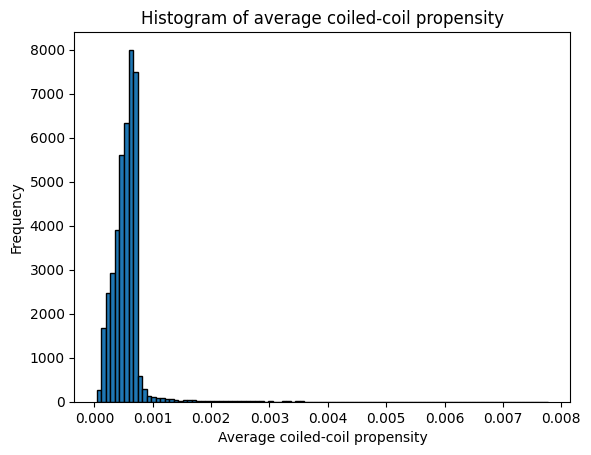

In [52]:
df.avg_cc.hist(bins=100, edgecolor='black', grid=False)  # ,log=True)
plt.title('Histogram of average coiled-coil propensity')
plt.xlabel('Average coiled-coil propensity')
plt.ylabel('Frequency')
plt.show()

In [53]:
prots = df.id.unique()
groups = clans_df.group_id.unique()

for group in groups:
    group_prots = clans_df[clans_df.group_id == group].numbers.values[0]
    
    group_df = df.iloc[group_prots]
    
    clans_df.loc[clans_df.group_id == group, 'mean_cc'] = group_df.avg_cc.mean()

clans_df

,group_id,type,hide,size,color,numbers,mean_cc
0,group_0,0,0,10,0;196;255;255,"[32770, 6, 32774, 9, 32779, 11, 32780, 32793, ...",0.000550
1,group_2,0,0,10,86;255;160;255,"[15360, 3074, 14338, 29189, 10246, 10247, 3021...",0.000522
2,group_3,0,0,10,0;212;255;255,"[23553, 17922, 15365, 23561, 9738, 15883, 4111...",0.000538
3,group_4,0,0,10,222;0;0;255,"[32258, 13832, 29197, 24083, 22036, 24087, 215...",0.000516
4,group_5,0,0,10,160;255;86;255,"[19457, 25089, 19971, 26628, 5127, 32777, 2920...",0.000522
...,...,...,...,...,...,...,...
132,group_1_1,0,0,10,255;215;0;255,"[20, 55, 64, 188, 189, 209, 251, 323, 633, 664...",0.000529
133,group_1_2,0,0,10,160;255;86;255,"[26, 35, 44, 73, 91, 96, 97, 128, 152, 177, 18...",0.000548
134,group_1_3,0,0,10,0;156;255;255,"[172, 197, 576, 577, 927, 1160, 1332, 1338, 13...",0.000519
135,group_1_4,0,0,10,0;64;255;255,"[387, 669, 1050, 1340, 2050, 2203, 2520, 2563,...",0.000517


Text(0, 0.5, 'Frequency')

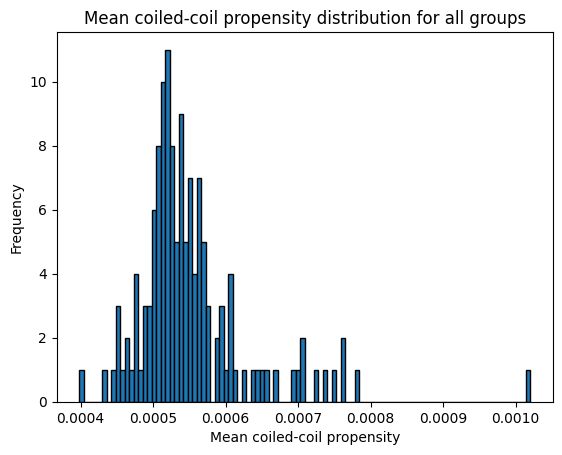

In [54]:
clans_df.mean_cc.hist(bins=100, edgecolor='black', grid=False)
plt.title('Mean coiled-coil propensity distribution for all groups')
plt.xlabel('Mean coiled-coil propensity')
plt.ylabel('Frequency')

### Visualize CC propensity in CLANS map

In [12]:
clans_data = "/ebio/abt1_share/prediction_hendecads/data/new_prot_fam_data/CLANS_cluster_map/new_hendecads_1E-14.clans"

with open(clans_data, 'r') as file:
    data = file.readlines()

data = [line.strip() for line in data]

'1 313.18863 -218.57608 0.0'

In [21]:
first_pos = 73772
last_pos = 73772 + 36455

pos = [x.split() for x in data[first_pos:last_pos]]

pos_df = pd.DataFrame(pos, columns=['prot_id', 'x', 'y', '_'])

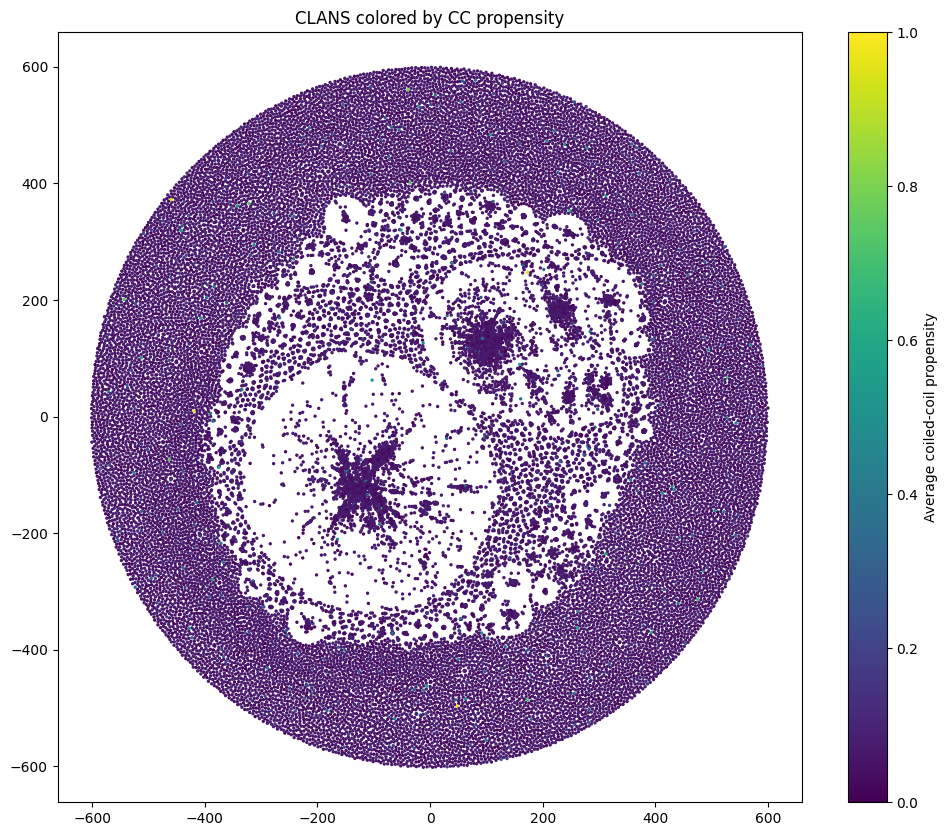

In [36]:
# Scatter plot of the proteins in the CLANS plot
pos_df.x = pos_df.x.astype(float)
pos_df.y = pos_df.y.astype(float)

# Use average CC values from df.avg_cc as color
pos_df['avg_cc'] = df.avg_cc
pos_df['avg_cc_norm'] = (pos_df.avg_cc - pos_df.avg_cc.min()) / (pos_df.avg_cc.max() - pos_df.avg_cc.min())

plt.figure(figsize=(12, 10))
plt.scatter(pos_df.x, pos_df.y, c=pos_df.avg_cc_norm, cmap='viridis', s=2)
plt.colorbar(label='Average coiled-coil propensity')
plt.title('CLANS colored by CC propensity')
plt.show()
